# About 
This notebook is used to fit the Collins fragmentation function using SIA data from BESIII only.  The results will be compared with a similar extraction from SIDIS, as well as SIA (Belle, BaBaR).

In [1]:
# Use this cell instead when running in jupyter.jlab.org

# import sys,os
# sys.path.insert(0, "/group/JAM/webfitter/tmd/fitpack")
# os.environ['FITPACK']="/group/JAM/webfitter/tmd/fitpack"
# from fitlab.resman import RESMAN

In [2]:
import sys,os
from fitlab.resman import RESMAN
from fitlab.mcsamp import MCSAMP
from tools.config import load_config,conf
from tools.tools import load, save,checkdir
import pylab as py
import numpy as np
import pandas as pd
import copy

import matplotlib.pyplot as plt

def lprint(msg):
    sys.stdout.write('\r')
    sys.stdout.write('%s' %msg)
    sys.stdout.flush()
%matplotlib inline

### Setup path to store the results 

In [3]:
path2results='sia_pion_bes3'
checkdir(path2results)

## SIA Datasets 
In this notebook only BESIII data is being fit.  Please see the following publication for details.
https://arxiv.org/abs/1507.06824

In [4]:
conf['datasets']={}
conf['datasets']['sia']={}
conf['datasets']['sia']['filters']={0:{'idx':None,'filter':None}}
conf['datasets']['sia']['filters'][0]['idx']=[3000,3001,3002,3003]
conf['datasets']['sia']['filters'][0]['filter']="Q2>1.69"
conf['datasets']['sia']['xlsx']={}
conf["datasets"]["sia"]["xlsx"][3000]="sia/expdata/3000.xlsx"  
conf["datasets"]["sia"]["xlsx"][3001]="sia/expdata/3001.xlsx"  
conf["datasets"]["sia"]["xlsx"][3002]="sia/expdata/3002.xlsx"  
conf["datasets"]["sia"]["xlsx"][3003]="sia/expdata/3003.xlsx"  

conf['datasets']['sia']['norm']={}
for k in conf['datasets']['sia']['xlsx']: 
    conf['datasets']['sia']['norm'][k]={'value':1,'fixed':True,'min':0,'max':1} 

## parameters

In [5]:
conf['params']={}
conf['shape']=1

### TMD PDF/FF parameters (from upol analysis)

In [6]:
conf['params']={}
conf['params']['pdf']={}
conf['params']['pdf']['widths0 valence']  = {'value':5.89294556274006398056e-01,'fixed':True,'min':0,'max':1}
conf['params']['pdf']['widths0 sea']      = {'value':6.33443286558464269120e-01,'fixed':True,'min':0,'max':1}
conf['params']['ff']={}
conf['params']['ff']['widths0 pi+ fav']   = {'value':1.15151579728561548333e-01,'fixed':True,'min':0,'max':1}
conf['params']['ff']['widths0 pi+ unfav'] = {'value':1.36784756168045196212e-01,'fixed':True,'min':0,'max':1}

### TMD Collins parameters

In [7]:
conf['params']['collins']={}
conf['params']['collins']['widths0 pi+ fav']     = {'value':7.47958632885192820083e-02,'fixed':False,'min':0.05,'max':0.10}
conf['params']['collins']['widths0 pi+ unfav']   = {'value':0.059763576917398841815e+00,'fixed':False,'min':0.05,'max':0.136784756168045196212}
conf['params']['collins']['pi+ u N 1']  = {'value': 4.49239476315589936206e+00,'fixed':False,'min':0,'max':3}
conf['params']['collins']['pi+ u a 1']  = {'value':-8.28098465048009213518e-01,'fixed':False,'min':-1.9,'max':0}
conf['params']['collins']['pi+ u b 1']  = {'value': 6.60780815284983358282e+00,'fixed':False,'min':2,'max':6}

conf['params']['collins']['pi+ d N 1']  = {'value':-4.14852904854067539020e+00,'fixed':False,'min':-12,'max':0.0}
conf['params']['collins']['pi+ d a 1']  = {'value': 1.00000000000000000000e+00,'fixed':False,'min': 0,'max':7.0}
conf['params']['collins']['pi+ d b 1']  = {'value': 2.37348461151638101541e+00,'fixed':False,'min':2.5,'max':4.0}

conf['params']['collins']['pi+ u c 1']  = {'value': 0.0,'fixed':True,'min':-10,'max':10}
conf['params']['collins']['pi+ d c 1']  = {'value': 0.0,'fixed':True,'min':-10,'max':10}
conf['params']['collins']['pi+ u d 1']  = {'value': 0.0,'fixed':True,'min':-10,'max':10}
conf['params']['collins']['pi+ d d 1']  = {'value': 0.0,'fixed':True,'min':-10,'max':10}

conf['params']['collins']['pi+ u N 2']  = {'value': 6.11150078306284516572e+00,'fixed':False,'min':0,'max':15}
conf['params']['collins']['pi+ u a 2']  = {'value': 4.71508421683099232524e+00,'fixed':False,'min':1,'max':8.0}
conf['params']['collins']['pi+ u b 2']  = {'value': 2.75387728005980081392e+00,'fixed':False,'min':0,'max':5}

conf['params']['collins']['pi+ d N 2']  = {'value': 0.0,'fixed':True,'min':-20,'max':0}
conf['params']['collins']['pi+ d a 2']  = {'value': 0.0,'fixed':True,'min':-1,'max':5}
conf['params']['collins']['pi+ d b 2']  = {'value': 0.0,'fixed':True,'min':1e-5,'max':10}
conf['params']['collins']['pi+ u c 2']  = {'value': 0.0,'fixed':True,'min':-10,'max':10}
conf['params']['collins']['pi+ d c 2']  = {'value': 0.0,'fixed':True,'min':-10,'max':10}
conf['params']['collins']['pi+ u d 2']  = {'value': 0.0,'fixed':True,'min':-10,'max':10}
conf['params']['collins']['pi+ d d 2']  = {'value': 0.0,'fixed':True,'min':-10,'max':10}

## Nested Sampling

### initialize fitpack libraries

In [8]:
conf['ncpus']=1
conf['resman'] = RESMAN()
mcsamp=MCSAMP()

loading sia data sets 3003
multiprocess setup: ncpus=1 / observable


### start multiple NS runs
- the code will start n independent runs specified by size

In [52]:
conf['size']=4
conf['factor']=2 # play with the factor (3,4) and the tolerance (1.e-5,1.e-10)
conf['tol']=1e-5
mcsamp.run(path2results)

iter=4511  logz=11.287 rel-err=9.791e-11  t-elapsed=4.189e+02  dchi2min=-1.910e+01 dchi2max=-1.910e+01

### combine multiple runs into one big run

In [53]:
MC=mcsamp.get_MC_samples(path2results+'/mcdata')

runs max likelihoods
-9.78275019770393
-9.766396611178516
-9.530214157609672
-9.99421384281756
-9.551393361485346
-9.328110663367447
-9.704261643646152
-9.61289769848744
sample  size= 33601
sample2 size= 1135


### Distribution of parameters
From the Nested sampling routine we have a collection of sampled points in the parameter space $\vec{\theta}_i$.  All samples are contained in the list called `samples`.  The samples which contribute more than 0.1% of the total evidence $Z$ are kept in the list `samples2`.

These samples are representative of the posterior distribution, 
$P(\vec{\theta}|d)$, where $d$ is the data used in the analysis.  They can be used to approximate the integrals 

$$E[f(\theta)] = \int f(\theta) P(\theta|d) d\theta \approx \sum_{i=1}^{N} f(\theta_i) w_i$$

$$Var[f(\theta)] = \int (f(\theta) - E[f(\theta)])^2 P(\theta|d) d\theta \approx \sum_{i=1}^{N} (f(\theta_i) - E[f(\theta)])^2 w_i$$

providing estimates and errors for our parameters and our observables.  Here $N$ is the number of samples in the list `samples2`.  The weights $w_i$ are associated with the contribution of each sample $\theta_i$ to the total evidence $Z$, and they sum to 1.

In [54]:
os.listdir(path2results+'/mcdata')

['9.dat', '11.dat', '7.dat', '6.dat', '8.dat', '4.dat', '10.dat', '5.dat']

     widths0 pi+ fav =    0.06975 +/-    0.00897
   widths0 pi+ unfav =    0.09410 +/-    0.01579
           pi+ u N 1 =    1.57947 +/-    0.55158
           pi+ u a 1 =   -1.07890 +/-    0.29386
           pi+ u b 1 =    3.94482 +/-    0.48634
           pi+ d N 1 =   -5.52621 +/-    2.54993
           pi+ d a 1 =    2.74701 +/-    0.96925
           pi+ d b 1 =    3.34819 +/-    0.25495
           pi+ u N 2 =    6.63948 +/-    2.57913
           pi+ u a 2 =    5.16275 +/-    1.23113
           pi+ u b 2 =    2.05937 +/-    0.57363


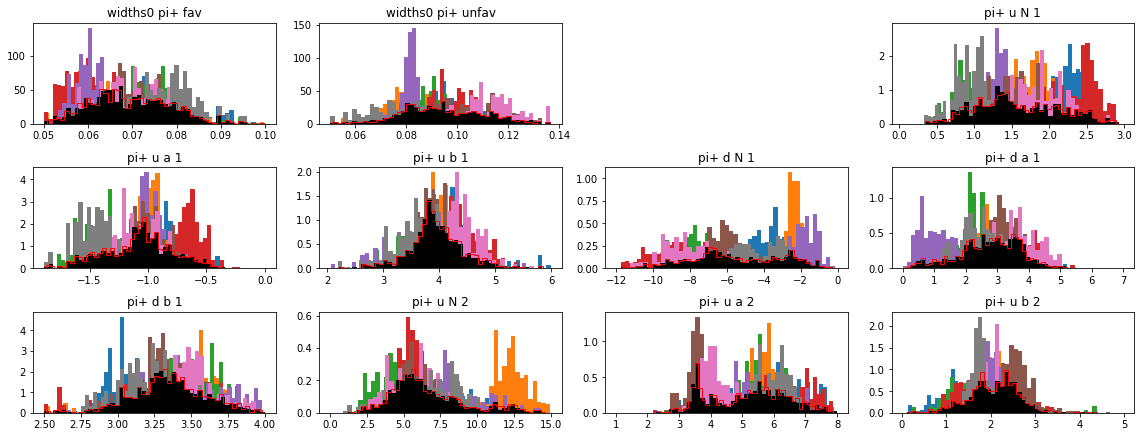

In [76]:
samples=MC['samples']
samples2=MC['samples2']
weights=MC['weights']
weights2=MC['weights2']
order=MC['order']
runs=MC['runs']

nrows,ncols=10,4
fig = py.figure(figsize=(ncols*4,nrows*2))

def get_idx(key,tag):
    for i in range(len(order)):
        if order[i][1]==key and order[i][2]==tag:
            return i

global cnt
cnt=0
def plot(tags):
    global cnt
    for i in range(1,len(tags)):
        cnt+=1
        if tags[i]==None: continue
        idx=get_idx(tags[0],tags[i])
        ax=py.subplot(nrows,ncols,cnt)
        vmin=np.amin(samples2.T[idx])
        vmax=np.amax(samples2.T[idx])
        R=None#(vmin,vmax)
        for k in runs:
            ax.hist(runs[k]['samples'].T[idx],weights=runs[k]['weights'],bins=50,normed=True,range=R)
        ax.hist(samples.T[idx],weights=weights,bins=50,color='k',normed=True,range=R)
        ax.hist(samples2.T[idx],weights=weights2,bins=50,color='r',histtype='step',normed=True,range=R)
        ax.set_title(tags[i])
        mean=np.einsum('i,i',samples2.T[idx],weights2)
        std=np.einsum('i,i',(samples2.T[idx]-mean)**2,weights2)**0.5
        print '%20s = %10.5f +/- %10.5f'%(tags[i],mean,std)
        #ax.set_xlim(vmin,vmax)
    py.tight_layout()

plot(['collins','widths0 pi+ fav','widths0 pi+ unfav',None])
plot(['collins','pi+ u N 1','pi+ u a 1','pi+ u b 1'])
plot(['collins','pi+ d N 1','pi+ d a 1','pi+ d b 1'])
plot(['collins','pi+ u N 2','pi+ u a 2','pi+ u b 2'])
plt.savefig('/home/dmriser/Pictures/collins-bes3-parameters.pdf',
           bbox_inches='tight')

## data vs theory

In [56]:
data={'weights':MC['weights2']}
cnt=0
for s in MC['samples2']:
    cnt+=1    
    lprint('%d/%d'%(cnt,len(MC['samples2'])))  
    conf['resman'].get_residuals(s);
    for k in conf['resman'].siares.tabs:
        if k  not in data: data[k]=[]
        thy=conf['resman'].siares.tabs[k]['thy']    
        norm=conf['datasets']['sia']['norm'][k]['value']
        shift=conf['resman'].siares.tabs[k]['shift']        
        data[k].append(shift+thy/norm)
save(data,'%s/%s'%(path2results,'sia.dat'))   

1135/1135

### compute averages and collect results

In [57]:
data=load('%s/%s'%(path2results,'sia.dat'))   
for k in data: data[k]=np.array(data[k])
thy,dthy={},{}
for k in data:
    if k=='weights': continue
    thy[k]=np.einsum('i,ik->k',data['weights'],data[k])
    dthy[k]=np.einsum('i,ik->k',data['weights'],(data[k]-thy[k])**2)**0.5
for k in thy: 
    conf['resman'].siares.tabs[k]['thy']=copy.copy(thy[k])
    conf['resman'].siares.tabs[k]['dthy']=copy.copy(dthy[k])

In [58]:
report=conf['resman'].gen_report(verb=0,level=1)
delimiters=[]
for i in range(len(report)): 
    if 'reaction:' in report[i]: 
        delimiters.append(i) 

data={}
nlines=len(report)
for i in range(len(delimiters)):
    ini=delimiters[i]
    if i==len(delimiters)-1: fin=len(report)
    else: fin=delimiters[i+1]
    reaction=report[ini].replace('reaction:','').strip()
    data[reaction]={'raw data':report[ini:fin]}
    
for k in data:
    print k
    block=data[k]['raw data']
    isep=[i for i in range(len(block)) if '--------' in block[i]][0]
    data[k]['summary']=[block[i] for i in range(isep)]
    data[k]['tables']=[block[i] for i in range(isep+1,len(block))]

    tabs={}
    for l in data[k]['tables']:
        info=l.split(',')
        col=[s for s in info if 'col' in s][0].split('=')[1].strip()
        if col not in tabs: tabs[col]={}
        info=[[ss.strip() for ss in s.split('=')] for s in info if 'col' not in info  if s.strip()!='']
        
        for s in info:
            if s[0] not in tabs[col]: tabs[col][s[0]]=[]
        
        for s in info:
            try:
                value=float(s[1])
            except:
                value=s[1]
            tabs[col][s[0]].append(value)        

    data[k]['tabs']=tabs
save(data,'%s/%s'%(path2results,'data_and_thy.dat'))

sia


In [59]:
def summary():
    for k in data:
        print ""
        for l in data[k]['summary']: print l
summary()


reaction: sia
   3000     BESIII     6       1.63       0.00       0.00
   3001     BESIII     6       0.76       0.00       0.00
   3002     BESIII     5       3.71       0.00       0.00
   3003     BESIII     5       1.76       0.00       0.00


### Plot data and theory

In [60]:
ALL=pd.concat([pd.DataFrame(conf['resman'].siares.tabs[idx]) \
              for idx in conf['resman'].siares.tabs.keys()])

ALL.columns

Index([          u'N',           u'Q',          u'Q2',     u'S2/1+C2',
             u'Shift',       u'alpha',        u'axis',         u'col',
              u'dthy',     u'hadron1',     u'hadron2',           u'i',
               u'obs',          u'pT', u'r-residuals',   u'residuals',
             u'shift',      u'stat_u',       u'sys_u',         u'thy',
             u'value',          u'z1',          u'z2'],
      dtype='object')

In [61]:
data = {}

for key, value in conf['resman'].siares.tabs.iteritems():
    data[key] = pd.DataFrame(value)

In [62]:
# from the paper https://arxiv.org/pdf/1309.5278.pdf
z1_bins = np.array([0.15, 0.2, 0.3, 0.4, 0.5, 0.7, 0.9])

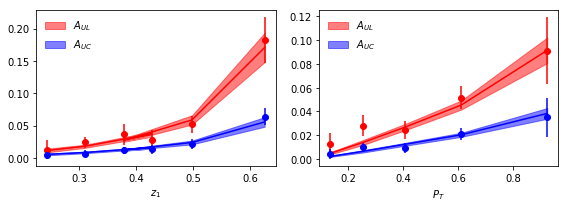

In [83]:
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.errorbar(data[3000].z1, 
             data[3000].value, 
             data[3000].alpha,
            marker='o',
            linestyle='',
            color='red')
plt.plot(data[3000].z1, data[3000].thy,
        color='red')
plt.fill_between(data[3000].z1, data[3000].thy-data[3000].dthy, 
                data[3000].thy+data[3000].dthy,
                color='red', alpha=0.5, label='$A_{UL}$')

plt.errorbar(data[3001].z1, 
             data[3001].value, 
             data[3001].alpha,
            marker='o',
            linestyle='',
            color='blue')
plt.fill_between(data[3001].z1, data[3001].thy-data[3001].dthy, 
                data[3001].thy+data[3001].dthy,
                color='blue', alpha=0.5, label='$A_{UC}$')
plt.plot(data[3001].z1, data[3001].thy,
        color='blue')
plt.xlabel('$z_1$')

# the legend has theory labels and I dont like them.
handles, labels = plt.gca().get_legend_handles_labels()
good_handles = []
good_labels = []
for handle, label in zip(handles, labels):
    if '$' in label:
        good_handles.append(handle)
        good_labels.append(label)            
plt.legend(good_handles, good_labels, frameon=False, loc='topleft')

plt.subplot(1,2,2)
plt.errorbar(data[3002].pT, 
             data[3002].value, 
             data[3002].alpha,
            marker='o',
            linestyle='',
            color='red')
plt.plot(data[3002].pT, data[3002].thy,
        color='red')
plt.fill_between(data[3002].pT, data[3002].thy-data[3002].dthy, 
                data[3002].thy+data[3002].dthy,
                color='red', alpha=0.5, label='$A_{UL}$')


plt.errorbar(data[3003].pT, 
             data[3003].value, 
             data[3003].alpha,
            marker='o',
            linestyle='',
            color='blue')
plt.plot(data[3003].pT, data[3003].thy,
        color='blue')
plt.fill_between(data[3003].pT, data[3003].thy-data[3003].dthy, 
                data[3003].thy+data[3003].dthy,
                color='blue', alpha=0.5, label='$A_{UC}$')
#plt.legend(frameon=False)
plt.xlabel('$P_T$')

 # the legend has theory labels and I dont like them.
handles, labels = plt.gca().get_legend_handles_labels()
good_handles = []
good_labels = []
for handle, label in zip(handles, labels):
    if '$' in label:
        good_handles.append(handle)
        good_labels.append(label)
            
plt.legend(good_handles, good_labels, frameon=False, loc='topleft')
plt.tight_layout()
plt.savefig('/home/dmriser/Pictures/bes3-asym.pdf',
           bbox_inches='tight')

## PDFs and FFs

In [65]:
def calc(func):
    RAW=[]
    cnt=0
    for s in MC['samples2']:
        cnt+=1    
        lprint('%d/%d'%(cnt,len(MC['samples2'])))  
        conf['parman'].set_new_params(s);    
        RAW.append(func())
    RAW=np.array(RAW)
    f =np.einsum('k,kif->if',MC['weights2'],RAW)
    df=np.einsum('k,kif->if',MC['weights2'],(RAW-f)**2)**0.5
    f=np.einsum('if->fi',f)
    df=np.einsum('if->fi',df)
    return {'f':f,'df':df}

In [66]:
Z1=10**np.linspace(-4,-2)
Z2=np.linspace(0.0101,0.999)
Z=np.append(Z1,Z2)
Hpi=calc(lambda : [conf['collins'].get_C(z,1,'pi+') for z in Z])

1135/1135

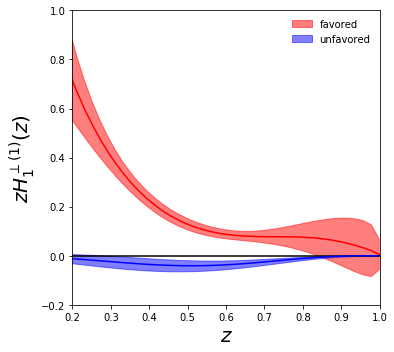

In [86]:
nrows,ncols=1,2
py.figure(figsize=(ncols*5,nrows*5))
ax=py.subplot(nrows,ncols,1)
ax.fill_between(Z,Z*(Hpi['f'][1]-Hpi['df'][1]),Z*(Hpi['f'][1]+Hpi['df'][1]),color='r',alpha=0.5,label='favored')
ax.fill_between(Z,Z*(Hpi['f'][3]-Hpi['df'][3]),Z*(Hpi['f'][3]+Hpi['df'][3]),color='b',alpha=0.5,label='unfavored')
ax.plot(Z,Z*0,'black')
ax.plot(Z,Z*Hpi['f'][1],'r')
ax.plot(Z,Z*Hpi['f'][3],'b')
ax.set_ylabel(r'$z H_1^{\perp (1)}(z)$',size=20)
ax.set_xlabel(r'$z$',size=20)
ax.set_ylim(-0.2,1.0)
ax.set_xlim(0.2,1.0)
py.legend(frameon=False)
py.tight_layout()
py.savefig('/home/dmriser/Pictures/collins-bes3.pdf', bbox_inches='tight')